# 4-1. 프로젝트: 뉴스기사 요약해보기
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [18]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')



print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

sunnysai12345/News_Summary
아래의 코드로 데이터를 다운로드할 수 있어요.

In [19]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [20]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [21]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [22]:
data.sample(10)

,headlines,text
48104,Teams post identical wins vs each other in bac...,Zimbabwe defeated Afghanistan by 154 runs in t...
46026,Snail race cancelled as cold makes competitors...,A pub in England has cancelled a charity snail...
83147,Six suspected ISIS terrorists arrested in Europe,Six suspected members of the Islamic State gro...
51058,"Mumbai marathoner suffers cardiac arrest, anot...",A 35-year-old half-marathon runner from Bengal...
22812,What led to the road safety protests in Bangla...,The road safety protests in Bangladesh began a...
96375,"True champs let their game do the talking, twe...",Reacting to India winning the Border-Gavaskar ...
1141,Pune girl forced to keep Ã¢ÂÂgod-givenÃ¢ÂÂ...,An incident of a 12-year-old Pune girl maintai...
80770,US firm Moon Express reveals plan to mine the ...,"US spaceflight company Moon Express, the first..."
14846,Can't hold others captive: Bedi on MLA who 'di...,After Puducherry Lieutenant Governor Kiran Bed...
51217,Kerala cops arrest journos protesting against ...,Kerala Police on Sunday arrested two journalis...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요.  
추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [23]:
# 중복 샘플과 NULL 값이 존재하는 샘플 제거
# 데이터의 중복 샘플 유무를 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [24]:
# 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


중복이 제거되면서 샘플 수가 98360개로 줄어들었어요. 그런데 만약 데이터 Null 값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있어요. 데이터에 Null 값이 남아있는지 볼게요.

데이터프레임에 Null 값이 있는지 확인하는 방법은 .isnull().sum()을 사용하면 알아볼 수 있어요.

In [25]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 텍스트 정규화와 불용어 제거
텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성

In [26]:
# from nltk.corpus import stopwords
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


하지만 아직 끝난 게 아니에요. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요. 이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요.

In [27]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있죠. 이를 사용하여 불용어를 제거할 거예요. 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.

In [28]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


전처리 전, 후의 결과를 확인하기 위해서 임의의 headlines와 text를 만들어 함수를 호출해 볼까요.

In [30]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었죠. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 또한 특수문자가 제거되면서 영어만 남았어요.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 이때, Text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

In [32]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 

clean_text = data['text'].apply(preprocess_sentence)

# 전처리 후 출력
clean_text.head(5)

0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object

이제 headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.

훈련 데이터 전체의 headlines 컬럼의 데이터를 전처리하는 코드를 작성

In [34]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 

clean_headlines = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체해요.

In [35]:
data['text'] = clean_text
data['headlines'] = clean_headlines
print(f"Length of clean_text: {len(clean_text)}")
print(f"Length of clean_headlines: {len(clean_headlines)}")
print(f"Length of data: {len(data)}")

# 빈 값을 Null 값으로 변환
# data.replace('', np.nan, inplace=True)
# print('=3')

Length of clean_text: 98360
Length of clean_headlines: 98360
Length of data: 98360


In [36]:
# 이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 해볼게요.
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 해요.

#### 샘플의 최대 길이 정하기
필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.
Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


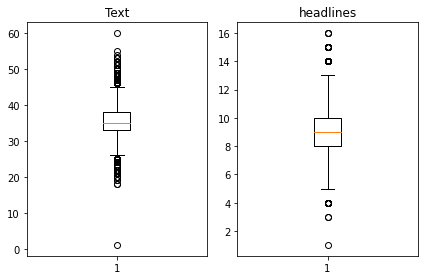

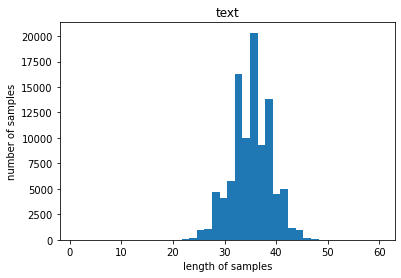

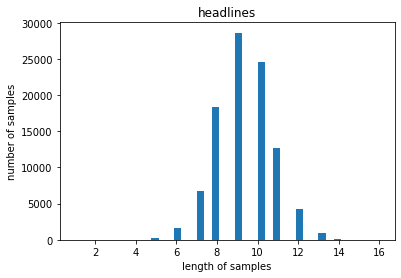

In [38]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 헤드라인의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있어요.

text의 경우 최소 길이가 1, 최대 길이가 60로 그 차이가 크죠. 하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 55 내외의 길이를 가진다는 것을 확인할 수 있어요.

headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 text에 비해 상대적으로 길이가 짧아요. 그래프로 봤을 때에도 대체적으로 13이하의 길이를 가지고 있네요.

이로부터 text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼게요.

In [40]:
text_max_len = 55
headlines_max_len = 13
print('=3')

=3


각각 55와 13로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [41]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


이렇게 만든 함수를 text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.

In [42]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 55 이하인 샘플의 비율: 0.9999898332655551
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


각각 55과 13로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, text 열의 경우에는 약 0.01%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

text와 headlines를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 headlines_max_len의 길이보다 큰 샘플을 제외하는 코드를 작성(apply 함수와 lamda식을 사용)

In [43]:
filtered_data = data[
    data['text'].apply(lambda x: len(x.split()) <= text_max_len) &
    data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)
]

# 전처리 후 결과를 확인
print("Filtered data head: ", filtered_data.head())

print('전체 샘플수 :', (len(data)))

Filtered data head:                                             headlines  \
0  upgrad learner switches to career in ml al wit...   
1  delhi techie wins free food from swiggy for on...   
2  new zealand end rohit sharma led india match w...   
3  aegon life iterm insurance plan helps customer...   
4  have known hirani for yrs what if metoo claims...   

                                                text  
0  saurav kant alumnus upgrad iiit pg program mac...  
1  kunal shah credit card bill payment platform c...  
2  new zealand defeated india wickets fourth odi ...  
3  aegon life iterm insurance plan customers enjo...  
4  speaking sexual harassment allegations rajkuma...  
전체 샘플수 : 98360


#### 시작 토큰과 종료 토큰 추가하기
앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억하시나요? 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.
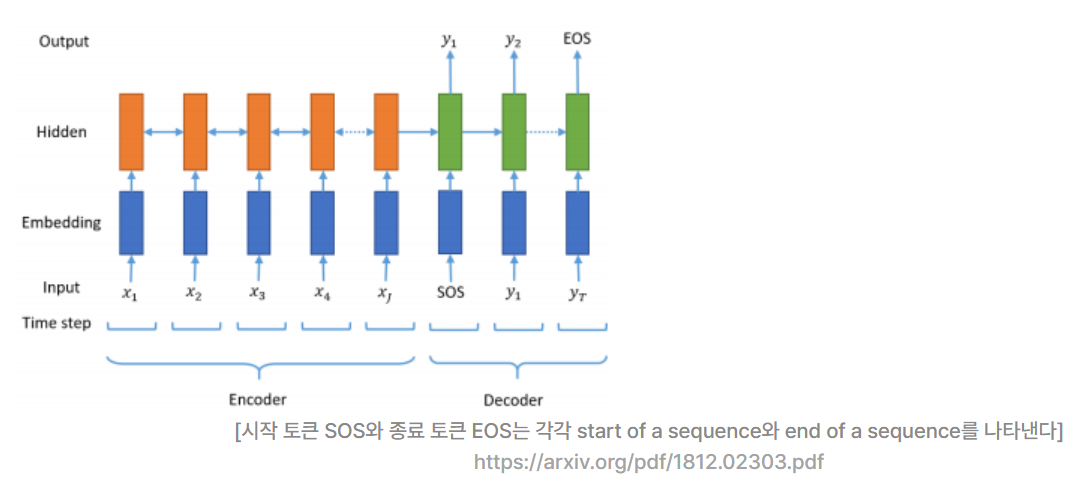

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 headlines 열로부터 만들 거예요.

In [44]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


앞뒤로 토큰이 잘 붙었는지 확인. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [45]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


이제 훈련 데이터와 테스트 데이터를 분리

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데, 여기서는 직접 해볼게요. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [46]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[33855 43004 13833 ... 93039 33042 24271]


In [47]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [48]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해 주세요.

In [49]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 데이터 전처리하기 (3) 정수 인코딩
단어 집합(vocabulary) 만들기 및 정수 인코딩
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [50]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [51]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69597
등장 빈도가 6번 이하인 희귀 단어의 수: 47420
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22177
단어 집합에서 희귀 단어의 비율: 68.13512076669971
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4876521081687053


encoder_input_train에는 47420 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.48%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [52]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [53]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1011, 300, 492, 1611, 1245, 4978, 3277, 695, 71, 860, 6722, 274, 4398, 6155, 7660, 860, 2086, 522, 2093, 1629, 300, 195, 139, 860, 127, 1028, 2086, 51, 1925, 522], [426, 1184, 1982, 1167, 45, 14, 21, 1403, 289, 699, 291, 2803, 21, 5663, 18, 699, 291, 2803, 1403, 1192, 25, 1167, 120, 1241, 5906, 21, 67, 18], [26, 45, 14, 1144, 887, 69, 1, 988, 1554, 621, 399, 781, 426, 200, 2087, 1094, 887, 988, 736, 457, 6, 47, 77, 3809, 48, 241, 3261, 3742, 887, 1, 3394, 3395, 10, 426, 5907]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

headlines 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.

In [54]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [55]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30036
등장 빈도가 5번 이하인 희귀 단어의 수: 19598
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10438
단어 집합에서 희귀 단어의 비율: 65.2483686243175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6476878163381645


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지하고 있네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.65%밖에 되지 않아요. 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요.

In [56]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 117, 6, 683, 9, 194, 1476, 104], [1, 384, 1454, 494, 5, 1355, 3, 161, 1336, 339], [1, 423, 3, 1020, 97, 384, 936, 44, 929], [1, 1925, 916, 1337, 929, 4, 198, 497, 6, 240], [1, 315, 1130, 167, 6, 30, 7, 427]]
target
decoder  [[117, 6, 683, 9, 194, 1476, 104, 2], [384, 1454, 494, 5, 1355, 3, 161, 1336, 339, 2], [423, 3, 1020, 97, 384, 936, 44, 929, 2], [1925, 916, 1337, 929, 4, 198, 497, 6, 240, 2], [315, 1130, 167, 6, 30, 7, 427, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

headlines문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 headlines문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 headlines문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [57]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 12
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 78676
훈련 레이블의 개수 : 78676
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인

#### 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [59]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')
# 이제 학습에 필요한 데이터 전처리가 모두 끝났어요

=3


## 모델 설계하기
우선 함수형 API를 이용해서 인코더를 설계해 볼게요.
인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성

In [60]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)


임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있어요. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이에요.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요. 즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.

아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것입니다. 색이 있는 화살표는 dropout을 나타낸 것이에요. 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있습니다. 그렇게 되면 오른쪽 그림과 같은 형태가 되겠군요. 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 해요.

#### 디코더 설계

In [61]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3]) # decoder_outputs -> 3

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더 출력층 설계

In [64]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

디코더의 출력층에서는 Summary?(headlines)의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘이에요.

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하세요.

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정

In [65]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

## 모델 훈련하기
설계한 모델을 가지고 훈련을 진행해볼게요.

In [66]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 60s 159ms/step - loss: 5.1432 - val_loss: 4.8321
Epoch 2/50
308/308 [==============================] - 49s 158ms/step - loss: 4.6098 - val_loss: 4.4165
Epoch 3/50
308/308 [==============================] - 49s 159ms/step - loss: 4.2361 - val_loss: 4.1313
Epoch 4/50
308/308 [==============================] - 49s 159ms/step - loss: 3.9731 - val_loss: 3.9376
Epoch 5/50
308/308 [==============================] - 49s 159ms/step - loss: 3.7884 - val_loss: 3.8083
Epoch 6/50
308/308 [==============================] - 48s 157ms/step - loss: 3.6390 - val_loss: 3.7024
Epoch 7/50
308/308 [==============================] - 49s 158ms/step - loss: 3.5076 - val_loss: 3.5961
Epoch 8/50
308/308 [==============================] - 49s 158ms/step - loss: 3.3934 - val_loss: 3.5176
Epoch 9/50
308/308 [==============================] - 49s 159ms/step - loss: 3.2942 - val_loss: 3.4637
Epoch 10/50
308/308 [==============================] - 49s 159ms/step - l

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정됨. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.

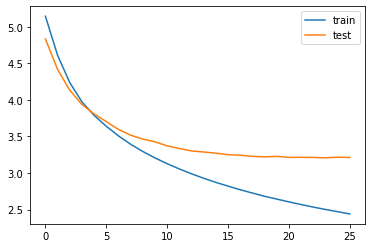

In [67]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [68]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [69]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3]) # state_h, state_c

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [70]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [71]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


정답 문장이 없는 추론(inference) 단계에서는 왜 모델 설계를 별도로 해주어야 하나요?   
생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문입니다.

## 모델 테스트하기
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠.   
주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요.   
함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

seq2text 함수처럼 headlines문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
(headlines문에는 sostoken과 eostoken을 고려)

In [72]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp

print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [74]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : hurricane harvey powerful storm hit texas years flooded estimated trillion litres water causing earth two area us based revealed notably solid layer rock lies partially layer called upper 
실제 요약 : sostoken forced earth down by cm 
예측 요약 :  world biggest hit by


원문 : state media released video showing president dressed outfit firing targets automatic rifle picking one weapons presented head state demonstrated aim served evidence high level military state news agency said 
실제 요약 : sostoken video prez himself as action 
예측 요약 :  video shows strikes in


원문 : indian wwe fighter mahal set fight former champion wwe championship belt wwe punjabi prison match july mahal defending title successfully defeating money bank notably two punjabi prison matches wwe history 
실제 요약 : sostoken mahal to fight in prison match 
예측 요약 :  mahal to get mahal at


원문 : pakistan opposition leader imran khan warned large protests article eligibility rules elected representatives conspiracy scrap article mak

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!   

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다. 이런 방안들에 대해서도 향후 살펴보게 될 것입니다.

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

## 추출적 요약 해보기
앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

seq2seq 모델을 사용하여 추상적 요약을 했습니다. 그렇다면 추출적 요약은 무엇일까요?   
추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식입니다.   
그래서 생성된 문장이나 단어는 원문에 포함되어 있기 때문에, 단점으로 언어 표현 능력이 제한되어 생성된 문장이 매끄럽지 않을 수 있습니다.   
대표적인 알고리즘으로는 TextRank가 있습니다.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?

### 패키지 설치
클라우드의 경우 이미 summa 가 설치돼있습니다. 확인해보고 싶으시면 아래 명령어를 Cloud Shell에서 실행해보세요!

$ pip list | grep summa

In [75]:
# 데이터 다운로드하기
import requests
from summa.summarizer import summarize

In [76]:
# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [77]:
# 이제 text에는 매트릭스 시놉시스가 문자열로 저장돼 있어요. 
# 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해볼게요.
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [78]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [79]:
# 만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [80]:
# 단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택하도록 해보세요.
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


### 수고하셨습니다.